# **Simulazione dell'agente Soft Actor-Critic**

Il Soft Actor-Critic (SAC) è un algoritmo di Deep Reinforcement Learning caratterizzato dall'approccio off-policy e l'entropia. Inoltre, SAC è progettato per operare efficacemente con spazi d'azione continui, rendendolo ideale per ambienti complessi come CityLearn. Questa versione di SAC è direttamente implementata dalla libreria ed non necessita l'utilizzo di wrapper per l'ambiente, in quanto la normalizzazione degli spazi viene effettuata direttamente dall'agente. Questa simulazione considera inoltre il SACRBC, e effettua varie valutazioni su simulazioni con diversi reward.

----

**Lista degli import**

In [1]:
from citylearn.agents.sac import SAC as Agent
from citylearn.agents.sac import SACRBC as RBCAgent
from citylearn.agents.rbc import OptimizedRBC as RBC
from citylearn.citylearn import CityLearnEnv
from citylearn.reward_function import * 

# Importo i reward corretti
from rewards.CityLearnReward import SolarPenaltyAndComfortReward

#import per strutture dati
import pandas as pd
from datetime import datetime

#import per grafici
from utils import plotting_functions as plt
from IPython.display import display, Markdown

#permette di nascondere i warning
import warnings
warnings.filterwarnings("ignore")


Couldn't import dot_parser, loading of dot files will not be possible.


In [2]:
# Inizializza l'ambiente
# citylearn_challenge_2023_phase_2_local_evaluation è una simulazione nel mese di GIUGNO
env = CityLearnEnv('citylearn_challenge_2023_phase_2_local_evaluation', central_agent=True)
envRBC = CityLearnEnv('citylearn_challenge_2023_phase_2_local_evaluation', central_agent=True)

# Imposto un nuovo reward, rispetto a quello impostato di default: Comfort Reward

rf = RewardFunction(env.schema)

env.reward_function = rf
envRBC.reward_function = rf
# Imposto l'edificio di confronto e quanti episodi vengono effettuati dagli agenti
num_building = 0
num_episodes = 20

# Esecuzione
model = Agent(env)
# Resetto la simulazione allo step iniziale
observations, _ = env.reset()
# Richiamo alla funzione base learn
model.learn(episodes=num_episodes, deterministic_finish=True)
# Esecuzione Versione RBC
modelRBC = RBCAgent(envRBC, RBC)
# Resetto la simulazione allo step iniziale
observations, _ = envRBC.reset()
# Richiamo alla funzione base learn
modelRBC.learn(episodes=num_episodes, deterministic_finish=True)




La funzione **learn()** esegue più episodi sull'ambiente: tutti tranne l'ultimo sono dedicati all'apprendimento, mentre l'ultimo viene eseguito in modalità **deterministic_finish**. In questa fase finale, l'agente utilizza esclusivamente la policy appresa per selezionare le azioni, senza ulteriori aggiornamenti o esplorazioni.


----

## **Confronto con Baseline**

In questa simulazione vengono esclusivamente confrontati gli algoritmi SAC e SACRBC, con il ComfortReward. La valutazione di altri reward viene lasciata alla relazione che raccoglierà solo i valori delle **cost_function**. I seguenti valori sono presi in considerazione come risultato di 4 episodi di training, in quanto risultano sufficienti al raggiungimento della convergenza.


In [3]:
# Vengono filtrare le cost_function desiderate
kpis_names = { 'electricity_consumption_total':'Consumo totale della rete',
               'carbon_emissions_total':'Emissioni',
              'discomfort_proportion':'Proporzione del tempo fuori dal comfort',
              
              #Qua si aggiungono cost_function
}

display(Markdown(f"### **SAC - Base Version**"))
display(Markdown("----"))

kpis = model.env.evaluate()
kpis = kpis[(kpis['cost_function'].isin(kpis_names))].dropna()
kpis = kpis.pivot(index='cost_function', columns='name', values='value').round(3)
display(kpis)

display(Markdown(f"### **SAC - RBC Version**"))
display(Markdown("----")) 

kpis = modelRBC.env.evaluate()
kpis = kpis[(kpis['cost_function'].isin(kpis_names))].dropna()
kpis = kpis.pivot(index='cost_function', columns='name', values='value').round(3)
display(kpis)


### **SAC - Base Version**

----

name,Building_1,Building_2,Building_3,District
cost_function,,,,
carbon_emissions_total,0.415,0.479,0.547,0.480
discomfort_proportion,0.980,0.912,0.978,0.957
electricity_consumption_total,0.418,0.491,0.555,0.488


### **SAC - RBC Version**

----

name,Building_1,Building_2,Building_3,District
cost_function,,,,
carbon_emissions_total,0.464,0.559,0.593,0.539
discomfort_proportion,0.954,0.834,0.927,0.905
electricity_consumption_total,0.471,0.569,0.600,0.547



------

## **Comportamento dei consumi**

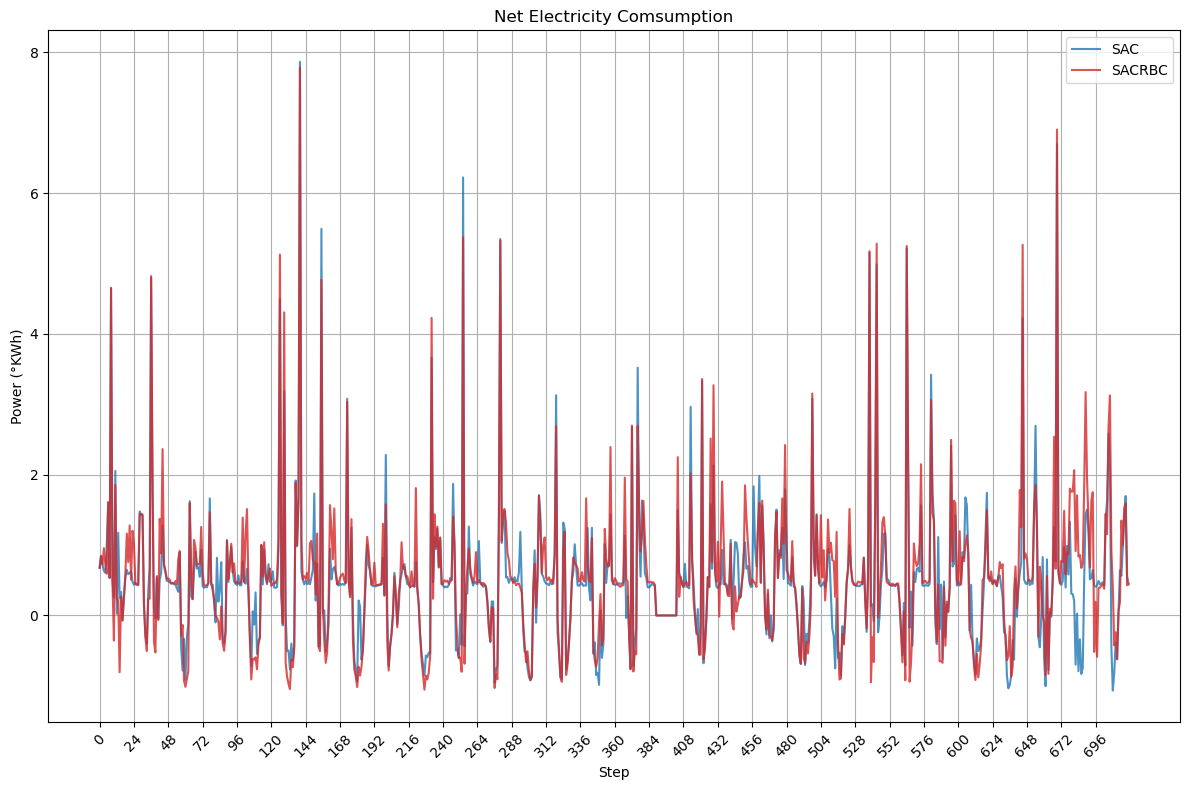

In [4]:
#Calcola il consumo di elettricità totale dell'edificio
energy_sac = env.buildings[num_building].net_electricity_consumption
energy_sacrbc = envRBC.buildings[num_building].net_electricity_consumption


plt.plot_comparison_two(
    energy_sac,
    energy_sacrbc,
    ylabel='Power (°KWh)',
    title='Net Electricity Comsumption',
    label1='SAC',
    label2='SACRBC'
)


------

## **Comportamento delle temperature**

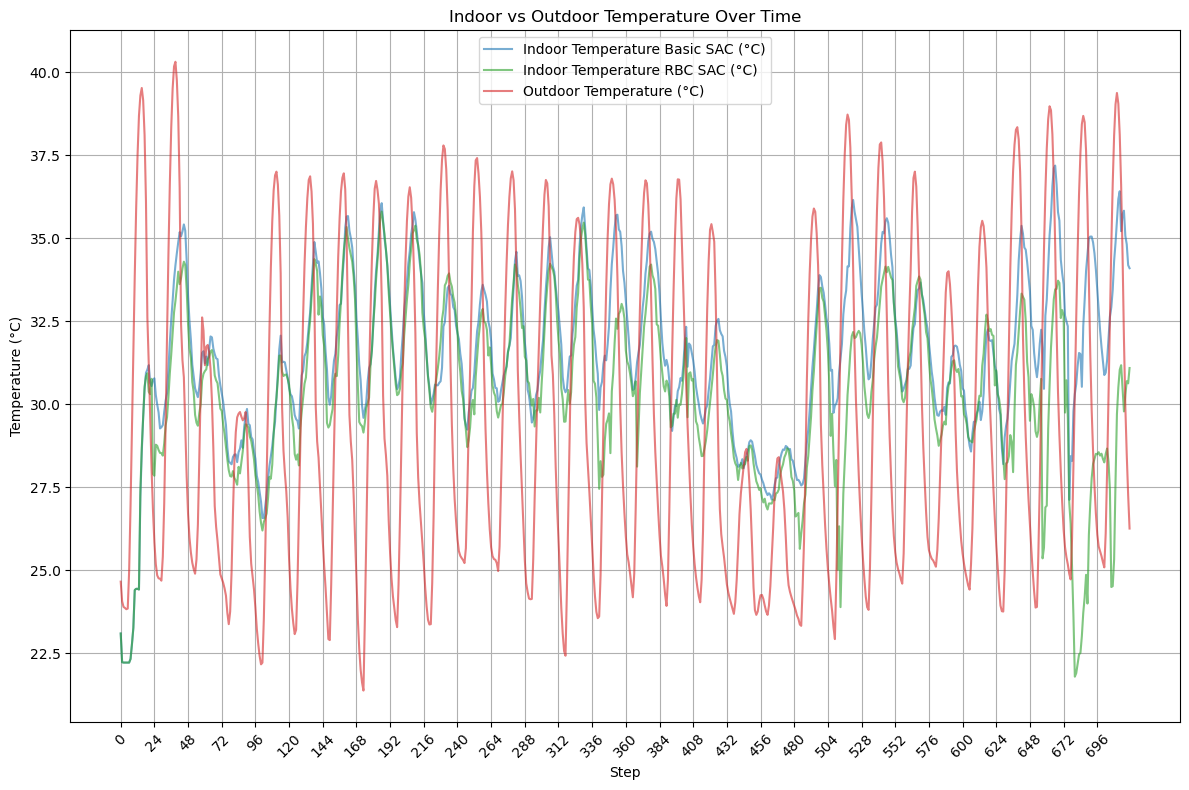

In [5]:
indoor_base_temp = env.buildings[num_building].indoor_dry_bulb_temperature
indoor_rbc_temp = envRBC.buildings[num_building].indoor_dry_bulb_temperature
outdoor_temp = env.buildings[num_building].weather.outdoor_dry_bulb_temperature


plt.plot_generic_comparison(
    indoor_base_temp,
    indoor_rbc_temp,
    outdoor_temp,
    ylabel='Temperature (°C)',
    title='Indoor vs Outdoor Temperature Over Time',
    labels=['Indoor Temperature Basic SAC (°C)','Indoor Temperature RBC SAC (°C)','Outdoor Temperature (°C)']
)


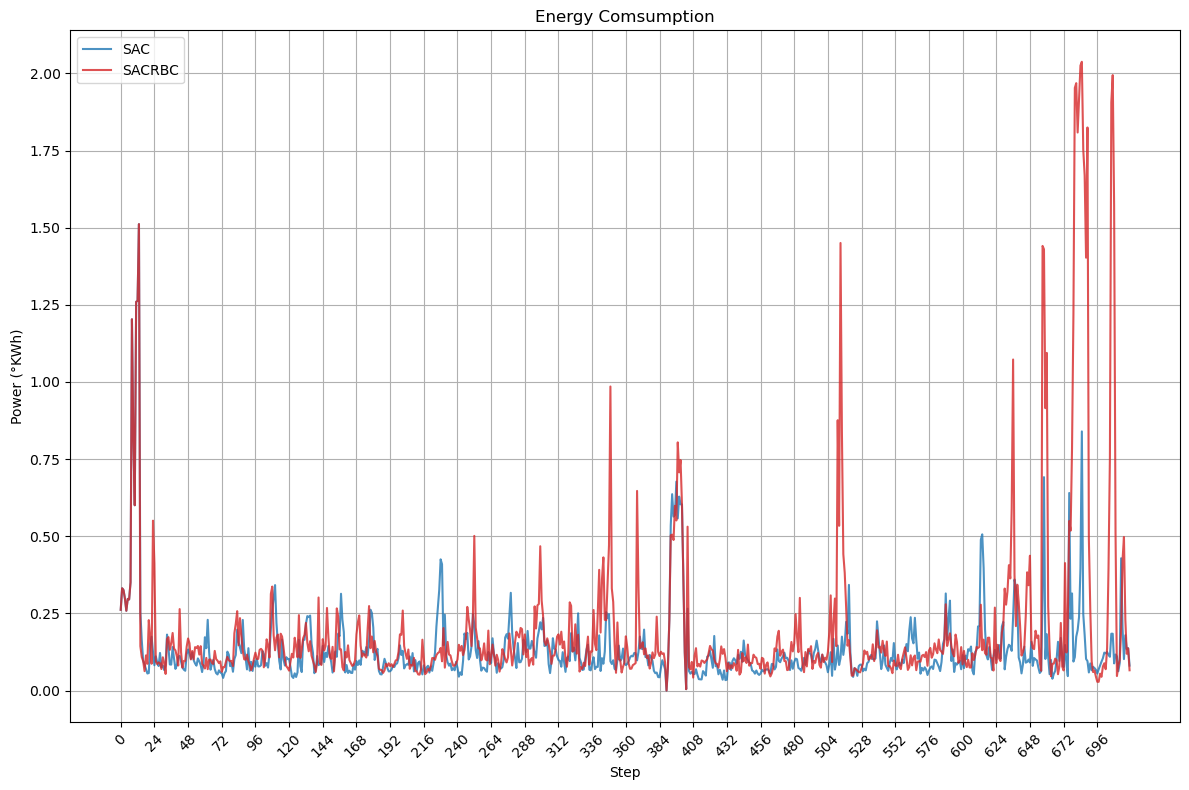

In [6]:
#Questa componente estrae la potenza utilizzata dei dispositivi che servono per regolare la temperatura ambientale

cooler_energy_sac = env.buildings[num_building].cooling_electricity_consumption
cooler_energy_sacrbc = envRBC.buildings[num_building].cooling_electricity_consumption

plt.plot_comparison_two(
    cooler_energy_sac,
    cooler_energy_sacrbc,
    ylabel='Power (°KWh)',
    title='Energy Comsumption',
    label1='SAC',
    label2='SACRBC'
)


----

## **Comportamento nell'utilizzo delle batterie**

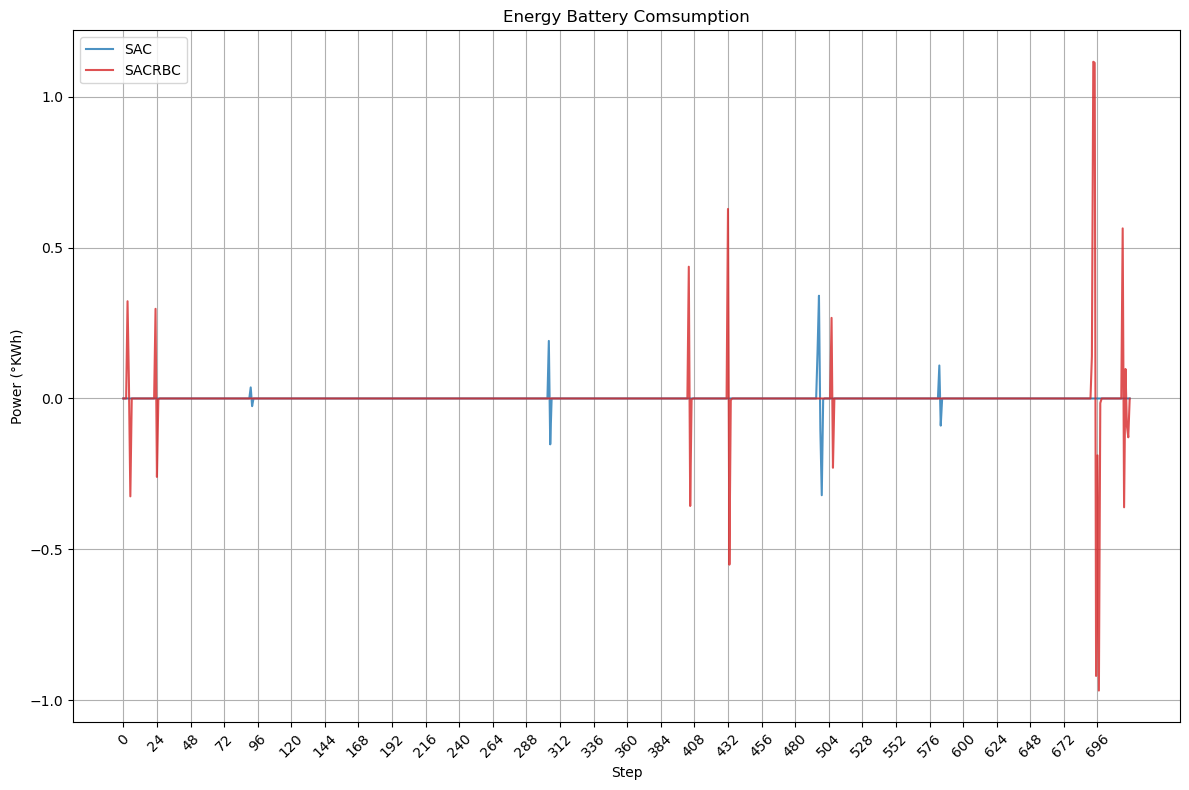

In [7]:
agent_data1 = env.buildings[num_building].electrical_storage_electricity_consumption
agent_data2 = envRBC.buildings[num_building].electrical_storage_electricity_consumption


plt.plot_comparison_two(
    agent_data1,
    agent_data2,
    ylabel='Power (°KWh)',
    title='Energy Battery Comsumption',
    label1='SAC',
    label2='SACRBC'
)


----

## **Comportamento delle emissioni**

L'emissioni sono strettamente legate ai consumi di energia della rete, perciò le caratteristiche precedenti si propagano anche qua.

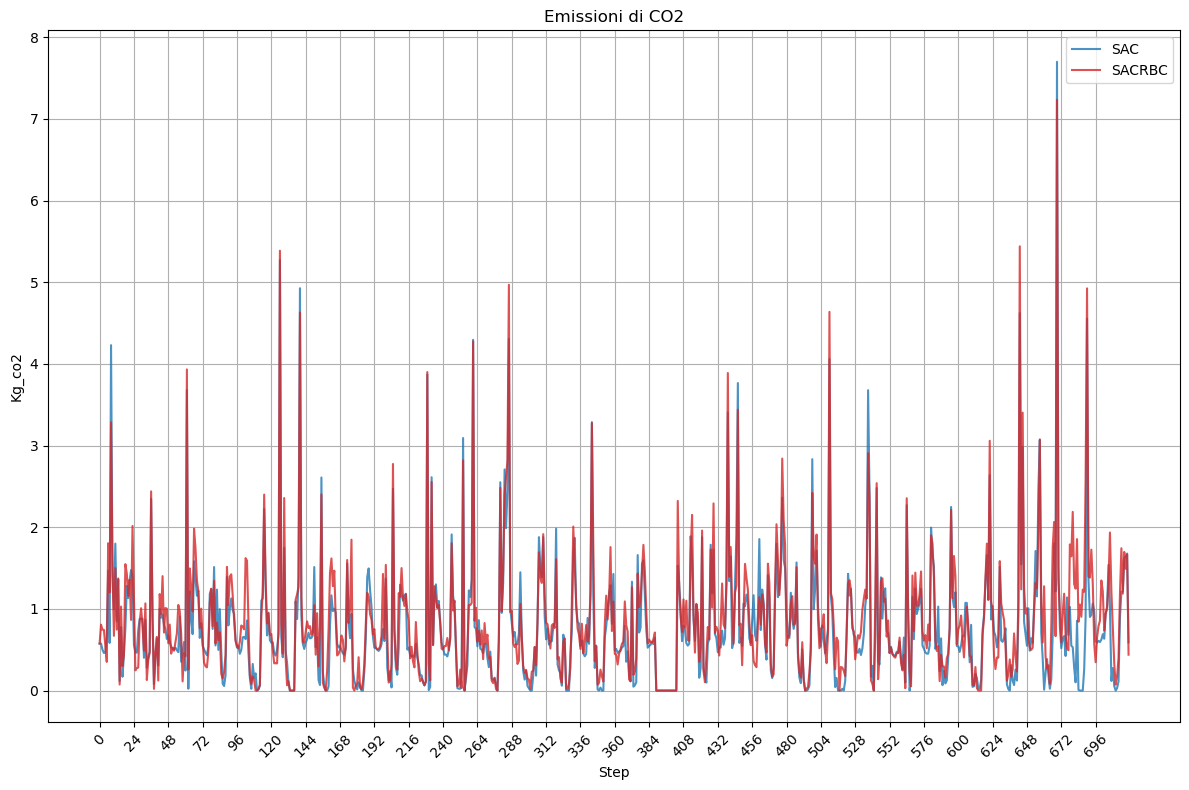

In [8]:
agent_data1 = env.net_electricity_consumption_emission
agent_data2 = envRBC.net_electricity_consumption_emission


plt.plot_comparison_two(agent_data1, agent_data2, ylabel='Kg_co2', title='Emissioni di CO2',label1='SAC',label2='SACRBC')


----

## **Comportamento dei reward e dell'apprendimento**



In [9]:
df = plt.create_episode_table(env.episode_rewards)

display(Markdown(f"### **SAC - Base Version**"))
display(Markdown("----"))
display(df)

dfrbc = plt.create_episode_table(envRBC.episode_rewards)
display(Markdown(f"### **SAC - RBC Version**"))
display(Markdown("----"))
display(dfrbc)


### **SAC - Base Version**

----

,Episodio,Reward Min,Reward Max,Reward Somma,Reward Media
0,1,-18.586601,0.0,-2669.829834,-3.713254
1,2,-16.612160,0.0,-1503.935547,-2.091705
2,3,-16.882034,0.0,-1427.090942,-1.984827
3,4,-17.018703,0.0,-1435.191528,-1.996094
4,5,-16.391165,0.0,-1538.992676,-2.140463
5,6,-16.648157,0.0,-1523.676147,-2.119160
6,7,-16.155882,0.0,-1502.114258,-2.089171
7,8,-16.559349,0.0,-1451.145020,-2.018282
8,9,-16.543831,0.0,-1465.040894,-2.037609
9,10,-16.107941,0.0,-1440.714355,-2.003775


### **SAC - RBC Version**

----

,Episodio,Reward Min,Reward Max,Reward Somma,Reward Media
0,1,-23.619841,0.0,-4423.453125,-6.152230
1,2,-17.119394,0.0,-1759.533447,-2.447195
2,3,-16.921638,0.0,-1546.090576,-2.150335
3,4,-16.251150,0.0,-1482.324707,-2.061648
4,5,-16.295662,0.0,-1555.571533,-2.163521
5,6,-16.301229,0.0,-1584.964478,-2.204401
6,7,-16.836161,0.0,-1602.217773,-2.228397
7,8,-17.374754,0.0,-1578.607544,-2.195560
8,9,-16.920332,0.0,-1589.212891,-2.210310
9,10,-16.694372,0.0,-1553.341187,-2.160419
